<p style="color:#737373; font-family:futura; font-size:200%;">Cross-Current Heat Exchanger</p>
<p style="color:#737373; font-family:futura;">2 February 2021</p>

<p style="font-family:futura;">Schematic Representation</p>
<img src="diagram.png" style="float: center;" width=500 height=500/>
<p style="font-family:futura;">The Boundary Value Problem</p>
Hot fluid:
$$\frac{dH^H}{dz} = - \frac{UP}{m_H} (T_H - T_C)\,\,; T_H(z=0) = T_H^{in}$$
Cold fluid:
$$\frac{dH^C}{dz} = - \frac{UP}{m_C} (T_H - T_C)\,\,; T_C(z=L) = T_C^{in}$$


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.integrate
import scipy.interpolate
import scipy.optimize
from matplotlib import style

from IPython.display import display, Math
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

style.use("classic")

<p style="font-family:futura;">List of compounds</p>

In [2]:
data = pd.read_csv("CpData.csv").replace(np.NaN, 0)
data.index += 1
comp = data['Name']
MW = data['Mol. wt.']
Tmin = data['Tmin, K']
Tmax = data['Tmax, K']
C1 = data['C1']
C2 = data['C2']
C3 = data['C3']
C4 = data['C4']
C5 = data['C5']
data

,Name,CAS no.,Mol. wt.,C1,C2,C3,C4,C5,"Tmin, K","Tmax, K"
1,Acetaldehyde,75-07-0,44.053,115100.0,-433.0000,1.42500,0.000000,0.000000,150.15,294.00
2,Acetamide,60-35-5,59.067,102300.0,128.7000,0.00000,0.000000,0.000000,354.15,571.00
3,Acetic acid,64-19-7,60.052,139640.0,-320.8000,0.89850,0.000000,0.000000,289.81,391.05
4,Acetic anhydride,108-24-7,102.089,36600.0,511.0000,0.00000,0.000000,0.000000,250.00,350.00
5,Acetone,67-64-1,58.079,135600.0,-177.0000,0.28370,0.000689,0.000000,178.45,329.44
...,...,...,...,...,...,...,...,...,...,...
233,Water,7732-18-5,18.015,276370.0,-2090.1000,8.12500,-0.014116,0.000009,273.16,533.15
234,p-Xylene,106-42-3,106.165,-35500.0,1287.2000,-2.59900,0.002426,0.000000,286.41,600.00
235,m-Xylene,108-38-3,106.165,133860.0,7.8754,0.52265,0.000000,0.000000,217.00,540.15
236,o-Xylene,95-47-6,106.165,36500.0,1017.5000,-2.63000,0.003020,0.000000,247.98,417.58


In [3]:
compH = 'o-Dichlorobenzene'    # HOT fluid
compC = 'Ethylene glycol'    # COLD fluid

In [4]:
iH = comp.index[comp == compH].tolist()[0]
iC = comp.index[comp == compC].tolist()[0]

In [5]:
Tref = 293.15  # K

def H_H(T):  # T in K, H in J/kg
    return (C1[iH] * (T - Tref) + C2[iH] * (T ** 2 - Tref ** 2) / 2 +
            C3[iH] * (T ** 3 - Tref ** 3) / 3 + C4[iH] * (T ** 4 - Tref ** 4) / 4 +
            C5[iH] * (T ** 5 - Tref ** 5) / 5) / MW[iH]


def H_C(T):  # T in K, H in J/kg
    return (C1[iC] * (T - Tref) + C2[iC] * (T ** 2 - Tref ** 2) / 2 +
            C3[iC] * (T ** 3 - Tref ** 3) / 3 + C4[iC] * (T ** 4 - Tref ** 4) / 4 +
            C5[iC] * (T ** 5 - Tref ** 5) / 5) / MW[iC]


# Using linear interpolation to find temperature at a given enthalpy value

T = np.linspace(max(Tmin[iH], Tmin[iC]), min(Tmax[iH], Tmax[iC]), 500)
T_H = scipy.interpolate.UnivariateSpline(H_H(T), T, k=1, s=0)
T_C = scipy.interpolate.UnivariateSpline(H_C(T), T, k=1, s=0)

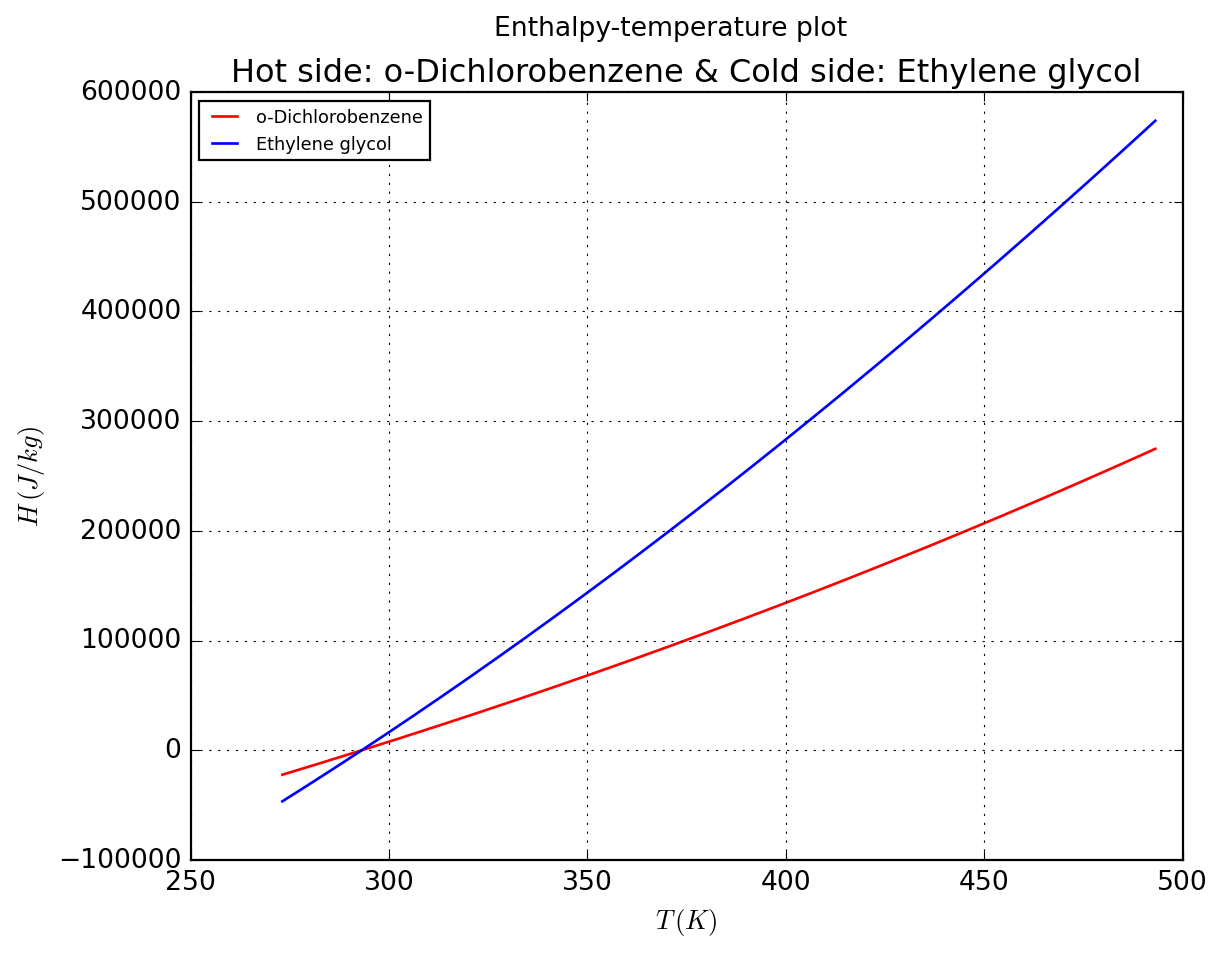

In [10]:
plt.figure(facecolor='white')
plt.grid()
plt.suptitle("Enthalpy-temperature plot")
plt.title("Hot side: %s & Cold side: %s" % (compH, compC))
plt.plot(T, H_H(T), color='red', linewidth=1.2, label=compH)
plt.plot(T, H_C(T), color='blue', linewidth=1.2, label=compC)
plt.xlabel(r'$T\, (K)$')
plt.ylabel(r'$H\, (J/kg)$')
plt.legend(loc='best', fontsize=8);

<p style="font-family:futura;">Shooting Method</p>

In [16]:
class CrossCurrentHX:
    def __init__(self):
        self.U = 350.0  # W/m2-K
        self.P = 0.1  # m2/m
        self.L = 1.0  # m

        self.mH = 0.01  # kg/s
        self.mC = 0.01  # kg/s
        self.T_Hin = 323.16  # K
        self.T_Cin = 303.16  # K

    def model(self, H, z):
        [H_H, H_C] = H

        dH_Hdz = -self.U * self.P * (T_H(H_H) - T_C(H_C)) / self.mH
        dH_Cdz = -self.U * self.P * (T_H(H_H) - T_C(H_C)) / self.mC

        return [dH_Hdz, dH_Cdz]

    def initialize(self):
        T = np.linspace(self.T_Cin, self.T_Hin, 1000)
        self.T_H = scipy.interpolate.UnivariateSpline(H_H(T), T, k=1, s=0)
        self.T_C = scipy.interpolate.UnivariateSpline(H_C(T), T, k=1, s=0)

    def shoot(self, T_Cout):
        self.T_Cout = T_Cout
        H0 = [H_H(self.T_Hin), H_C(self.T_Cout)]
        z = [0, self.L]

        solution = scipy.integrate.odeint(self.model, H0, z)
        H_Cin = solution[-1, 1]
        T_Cin = T_C(H_Cin)

        error = [T_Cin - self.T_Cin]
        return error

    def solve(self, n=100):
        self.initialize()

        guess = [self.T_Cin + 0.0]

        lsq = scipy.optimize.least_squares(self.shoot, guess)

        H0 = [H_H(self.T_Hin), H_C(self.T_Cout)]
        z = np.linspace(0, self.L, n)

        sol = scipy.integrate.odeint(self.model, H0, z)
        H_Hsol = sol[:, 0]
        H_Csol = sol[:, 1]

        self.dfsol = pd.DataFrame({"z": z,
                                   "T_H": self.T_H(H_Hsol),
                                   "T_C": self.T_C(H_Csol)})

In [17]:
hx = CrossCurrentHX()
hx.solve()

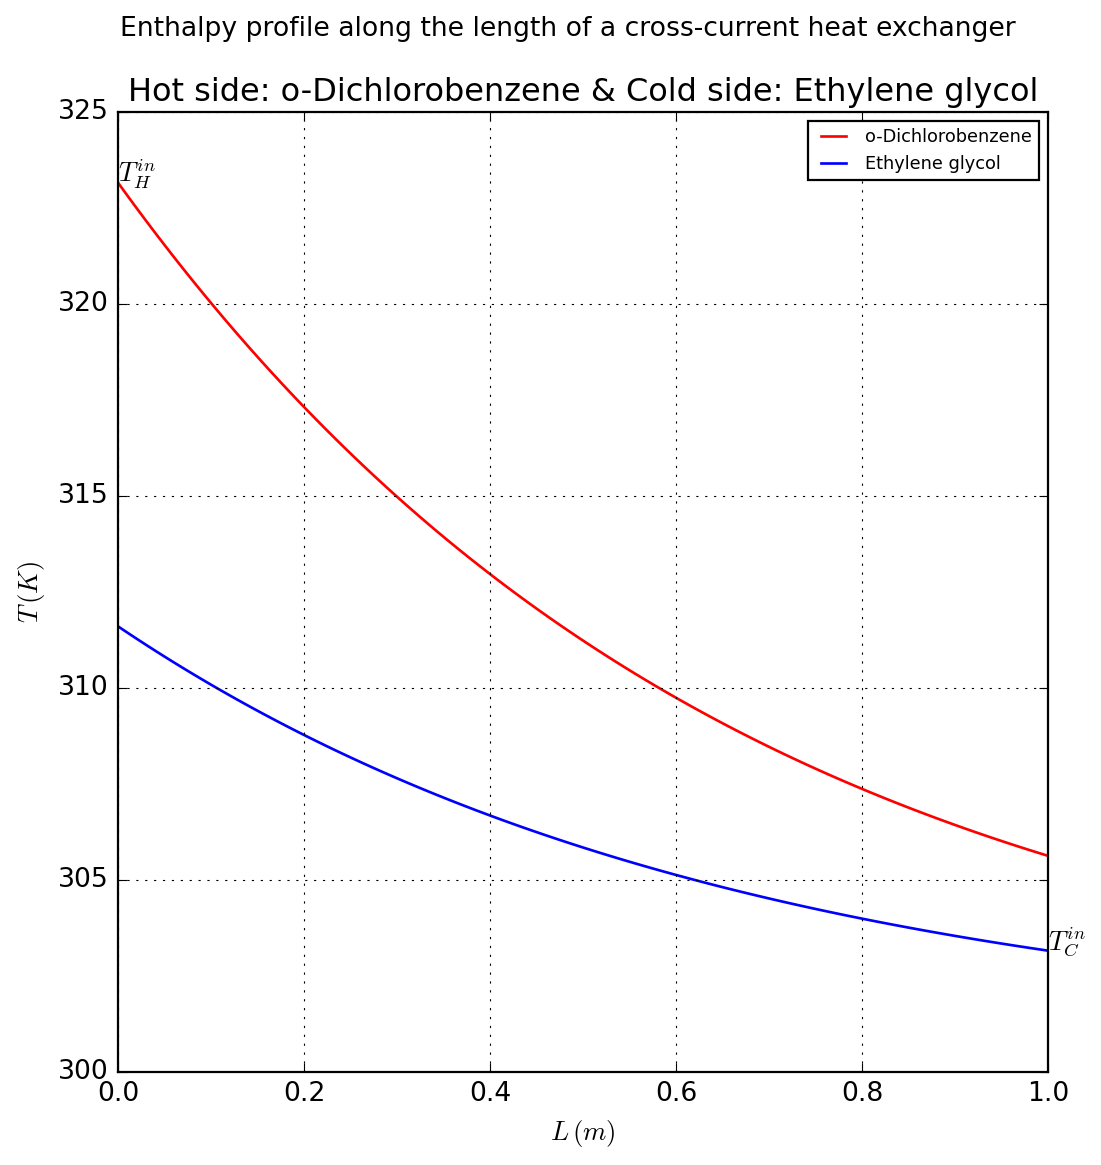

In [18]:
plt.figure(facecolor='white', figsize=(7.5, 7.5))
plt.grid()
plt.suptitle("Enthalpy profile along the length of a cross-current heat exchanger")
plt.title("Hot side: %s & Cold side: %s" % (compH, compC))
plt.plot(hx.dfsol.z, hx.dfsol.T_H, color='red', linewidth=1.2, label=compH)
plt.plot(hx.dfsol.z, hx.dfsol.T_C, color='blue', linewidth=1.2, label=compC)
plt.annotate(r'$T_H^{in}$', xy=(0, hx.T_Hin))
plt.annotate(r'$T_C^{in}$', xy=(hx.L, hx.T_Cin))
plt.xlabel(r'$L\, (m)$')
plt.ylabel(r'$T\, (K)$')
plt.legend(loc='best', fontsize=8);

---
<p style="color:#737373; font-family:futura;">Source: Perry, R. H., &amp; Green, D. W. (2008). Physical and Chemical Data. In Perry's chemical engineers' handbook (pp. 165-170). McGraw Hill.</p>